<font size="5">
 <div class="alert alert-block alert-info"><b>Master in Data Science - ISCTE <b>
     </div>
</font>   
    
<font size="5"> OEOD </font>

<font size="3"> Afonso Fareleiro - Armando Ferreira - Tomás Carvalho </font>
  
<font size="3"> Group 12 - 'MU' Micron Technology, Inc 

# RL for algorithmic trading

In [1]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
import gymnasium as gym
import quantstats as qs
import itertools
from tqdm import tqdm

# High-quality figures
%config InlineBackend.figure_format = 'svg'

## 1. Obtain/Extract the historical stock prices

In [2]:
# Historical stock price data for MU, from the period 2019 to 2023
## 'MU - Micron Technology, Inc' is an US based semiconductor company

mu = yf.Ticker("MU")
mu_data = mu.history(start="2019-01-01", end="2023-09-30")

mu_data.info()
mu_data.tail()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1195 entries, 2019-01-02 00:00:00-05:00 to 2023-09-29 00:00:00-04:00
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Open          1195 non-null   float64
 1   High          1195 non-null   float64
 2   Low           1195 non-null   float64
 3   Close         1195 non-null   float64
 4   Volume        1195 non-null   int64  
 5   Dividends     1195 non-null   float64
 6   Stock Splits  1195 non-null   float64
dtypes: float64(6), int64(1)
memory usage: 74.7 KB


,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2023-09-25 00:00:00-04:00,68.176264,69.074767,67.497396,68.465782,14900000,0.0,0.0
2023-09-26 00:00:00-04:00,67.856800,68.935003,67.477428,67.826851,12752500,0.0,0.0
2023-09-27 00:00:00-04:00,68.006551,68.735331,66.638830,68.096397,20852300,0.0,0.0
2023-09-28 00:00:00-04:00,65.860130,66.978259,63.723694,65.091408,46749800,0.0,0.0
2023-09-29 00:00:00-04:00,66.249478,68.615533,66.249478,67.916695,24307500,0.0,0.0


<Axes: xlabel='Date'>

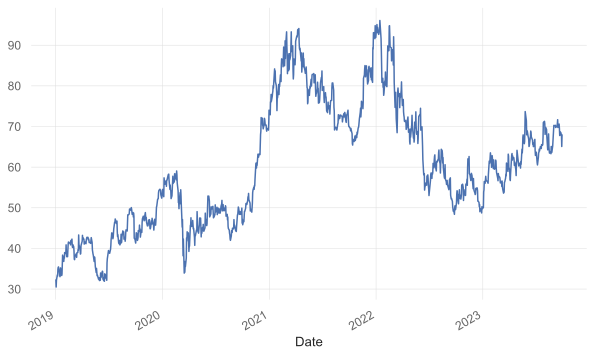

In [3]:
# Daily close price data for MU
mu_data.Close.plot()

## 2. Calculate returns, expected mean returns and risk

In [4]:
# Asset Returns/Rate of Returns: the cumulative daily rate of return is useful to determine /
#                                   the value of an investment at regular intervals.
data_close = mu_data[['Close']]
data_close.columns = ['MU']

returns = np.log(data_close / data_close.shift(1))
returns = returns.dropna()

# Expected Mean Returns
mean_returns = returns.mean()

# Volatility: market volatility is defined as the standard deviation of prices/returns.
vol = returns.std()

# Gain-Loss Ratio (GLR) represents the relative relationship of trades with a positive /
#                                       return and trades with a negative return
glr = returns[returns['MU'] > 0].sum() / returns[returns['MU'] < 0].sum().abs()

# Sharpe Ratio (SR) is the amount of excess return over the risk-free rate as the relevant measure of risk.
## rf is daily risk free rate.
# rf = (1.02 ** (1 / 360)) - 1

risk_free_rate = 0
sr = (mean_returns - risk_free_rate) / vol

# Compound Annual Growth Rate (CAGR)
cumulative_returns = returns.cumsum()
num_trading_days = len(returns)
cagr = (cumulative_returns['MU'][-1]) ** (252/num_trading_days) - 1

# Variance
var = returns.var() * 252

# CVAR
cvar = returns[returns <= np.percentile(returns, 5)].mean() * 252

# See metrics in table format
data_summary = pd.DataFrame({
    'Mean Returns': mean_returns,
    'Volatility': vol,
    'Gain-Loss Ratio (GLR)': glr,
    'Sharpe Ratio (SR)': sr,
    'CAGR': cagr,
    'Variance': var,
    'CVAR': cvar
})

data_summary


C:\Users\Admin\AppData\Local\Temp\ipykernel_13540\1702605445.py:29: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  cagr = (cumulative_returns['MU'][-1]) ** (252/num_trading_days) - 1


,Mean Returns,Volatility,Gain-Loss Ratio (GLR),Sharpe Ratio (SR),CAGR,Variance,CVAR
MU,0.000624,0.029188,1.059818,0.02138,-0.060209,0.214685,-16.058261


## 3. Define statistical trading strategy (at least one, maximum 2)

In [5]:
# Exponential moving average (EMA) strategy
def ema_strategy(data, small, large):
    # Define your trading strategy based on the historical data
    # Example: Buy when the 20-day moving average is above the 100-day moving average, sell otherwise
    signals = pd.DataFrame(data)

    # EMA for 20 and 100-day windows
    signals['ema_short'] = signals['Close'].ewm(span = small, adjust = False).mean()
    signals['ema_long'] = signals['Close'].ewm(span = large, adjust = False).mean()
                         
    # Define a crossover strategy
    signals['bullish'] = 0.0
    signals['bullish'] = np.where(signals['ema_short'] > signals['ema_long'], 1, 0)
    signals['crossover'] = signals['bullish'].diff()

    # Calculate passive and strategy's returns
    signals['returns'] = np.log(signals['Close'] / signals['Close'].shift(1))
    signals['strategy'] = signals['bullish'].shift(1) * signals['returns']
    
    return signals

C:\Users\Admin\AppData\Local\Temp\ipykernel_13540\3328235721.py:15: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ax.plot(ema_strat['ema_long'][idx], 'ro', markersize = 5, color='#6a994e')
C:\Users\Admin\AppData\Local\Temp\ipykernel_13540\3328235721.py:15: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro" (-> color='r'). The keyword argument will take precedence.
  ax.plot(ema_strat['ema_long'][idx], 'ro', markersize = 5, color='#6a994e')


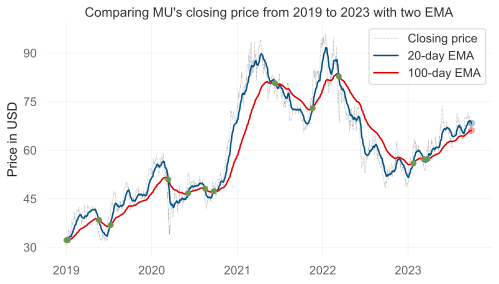

In [6]:
# Initiate strategy
ema_strat = ema_strategy(mu_data, 20, 100)

# Plot exponential moving averages for our strategy
# fig, ax = plt.subplots(figsize=(13.33,7.5), dpi = 96)
fig, ax = plt.subplots(figsize=(8, 5))
ax.plot(ema_strat['Close'], label='Closing price', color='grey', linestyle=':', linewidth=0.5)
ax.plot(ema_strat['ema_short'], label='20-day EMA', color='#014f86')
ax.plot(ema_strat.index[-1], ema_strat['ema_short'].iloc[-1], 'o', markersize=6, alpha=0.3, color='#014f86')
ax.plot(ema_strat['ema_long'], label='100-day EMA', color='#DC0000')
ax.plot(ema_strat.index[-1], ema_strat['ema_long'].iloc[-1], 'o', markersize=6, alpha=0.3, color='#DC0000')

# Plot crossovers
idx = np.argwhere(ema_strat['crossover']).flatten()
ax.plot(ema_strat['ema_long'][idx], 'ro', markersize = 5, color='#6a994e')

# Add Legend and Labels
ax.legend(loc='best')

# Prettify

## Create the grid 
ax.grid(which="major", axis='x', color='#DAD8D7', alpha=0.5, zorder=1)
ax.grid(which="major", axis='y', color='#DAD8D7', alpha=0.5, zorder=1)

## Reformat y-axis
ax.set_ylabel('Price in USD')
ax.yaxis.set_major_locator(plt.MaxNLocator(5))

## Remove the spines
ax.spines[['top','right','bottom']].set_visible(False)

## Make the left spine thicker
ax.spines['left'].set_linewidth(1.1)
# Add in title and subtitle
ax.set_title(label="Comparing MU's closing price from 2019 to 2023 with two EMA")
## Adjust the margins around the plot area
plt.subplots_adjust(left=None, bottom=0.2, right=None, top=0.85, wspace=None, hspace=None)

# Show the plot
plt.show()


<Axes: title={'center': 'Strategy Positioning'}, xlabel='Date'>

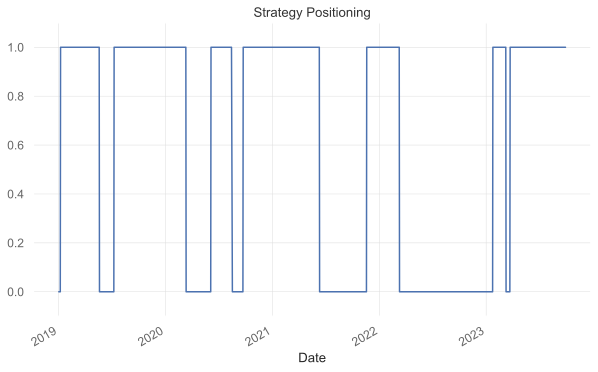

In [7]:
# Plot our strategy's positions
ema_strat['bullish'].plot(ylim=[-0.1, 1.1],
title='Strategy Positioning',
figsize=(10, 6))

returns     187.767570
strategy     29.788872
dtype: float64

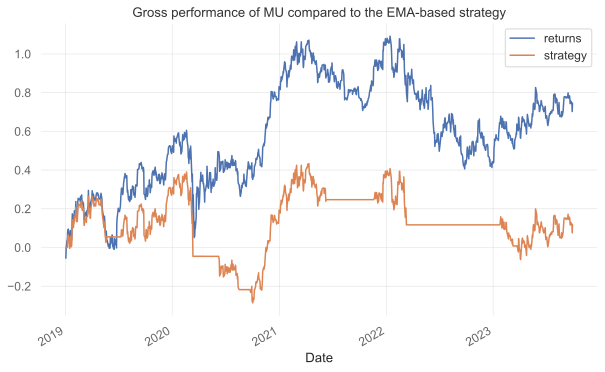

In [8]:
# Plot our strategy's returns compared to MU's stock performance
ema_strat[['returns', 'strategy']].cumsum().plot(figsize=(10, 6), 
                                                         title="Gross performance of MU compared to the EMA-based strategy")

ema_strat[['returns', 'strategy']].sum() * 252

## 4. Evaluate the efficacy of the trading strategy

In [9]:
qs.reports.metrics(ema_strat['strategy'])

                    Strategy
------------------  ----------
Start Period        2019-01-03
End Period          2023-09-29
Risk-Free Rate      0.0%
Time in Market      61.0%

Cumulative Return   -14.63%
CAGR﹪              -2.28%

Sharpe              0.07
Prob. Sharpe Ratio  56.32%
Sortino             0.1
Sortino/√2          0.07
Omega               1.02

Max Drawdown        -51.57%
Longest DD Days     1318

Gain/Pain Ratio     0.02
Gain/Pain (1M)      0.08

Payoff Ratio        0.98
Profit Factor       1.02
Common Sense Ratio  1.01
CPC Index           0.51
Tail Ratio          0.99
Outlier Win Ratio   6.5
Outlier Loss Ratio  2.64

MTD                 -3.04%
3M                  0.22%
6M                  11.14%
YTD                 -4.11%
1Y                  -4.11%
3Y (ann.)           4.68%
5Y (ann.)           -2.28%
10Y (ann.)          -2.28%
All-time (ann.)     -2.28%

Avg. Drawdown       -12.18%
Avg. Drawdown Days  170
Recovery Factor     0.23
Ulcer Index         0.29
Serenity Index      

## 5. Training a Deep Q-learning model in stock trading

In [10]:
# Import libraries for environment and model
from gym_anytrading.envs import StocksEnv, Actions, Positions
from stable_baselines3 import DQN

In [11]:
# Create a gym_anytrading environment using MU's stock data
env = gym.make('stocks-v0',
    df = pd.DataFrame(mu_data['Close']),
    window_size = 10,
    frame_bound = (10, len(mu_data)),
)

In [16]:
# Create a DQN model and set parameters
model = DQN("MlpPolicy",
            env = env,
            buffer_size = 5000, #number of old observation steps saved ### podem aumentar 10000 ou 20000
            learning_starts = 200, # memory warmup ## podem aumentar 500, 1000
            train_freq = 1, # prediction network gets an update each train_freq's step ### aqui podem alterar 1,2,3,4
            batch_size = 4, # mini batch size drawn at each update step ### 8,16,32
            policy_kwargs = {'net_arch': [50,50]}, # hidden layer size of MLP ### podem alterar camadas e neurónios por camada: [100], [10,20],[50,100]
            exploration_fraction = 0.1, # Fraction of training steps the epsilon decays ### alterar aqui; 0.05, ou 0.2 
            target_update_interval = 100, # Target network gets updated each target_update_interval's step
            gamma = 0.9,
            verbose = 1, # verbosity of stable-basline's prints
            tau = 1e-4, ### fazer com 1e-5  (leva mais tempo),
            seed = 2023
            )

simulation_time = 5
tau = 1e-4
nb_steps = int(simulation_time // tau)

# Initiate learning
model.learn(total_timesteps= nb_steps, log_interval=4)

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.18e+03 |
|    ep_rew_mean      | 4.68     |
|    exploration_rate | 0.1      |
| time/               |          |
|    episodes         | 4        |
|    fps              | 425      |
|    time_elapsed     | 11       |
|    total_timesteps  | 4736     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00346  |
|    n_updates        | 4535     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.18e+03 |
|    ep_rew_mean      | 15.9     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8        |
|    fps              | 398      |
|    time_elapsed     | 23       |
|    total_timesteps  | 9472     |
| train/              |        

In [13]:
# Save learned model as a zip file
# model.save("dqn_mu")

# Load saved model (zip file)
#model = DQN.load("dqn_mu")

In [29]:
# Reset environment to its initial state
observation, info = env.reset(seed=2023)

# Initiate dictionary to store action counts
action_stats = {Actions.Sell: 0, Actions.Buy: 0}

# Loop to apply the trained model on the environment
while True:
    action, _states = model.predict(observation)
    action_stats[Actions(action)] += 1
    observation, reward, terminated, truncated, info = env.step(action)

    if terminated or truncated:
        print("info:", info)
        print("action_stats:", action_stats)
        break

env.close()

info: {'total_reward': 11.831192016601562, 'total_profit': 0.8250073643329224, 'position': <Positions.Long: 1>}
action_stats: {<Actions.Sell: 0>: 39, <Actions.Buy: 1>: 1145}


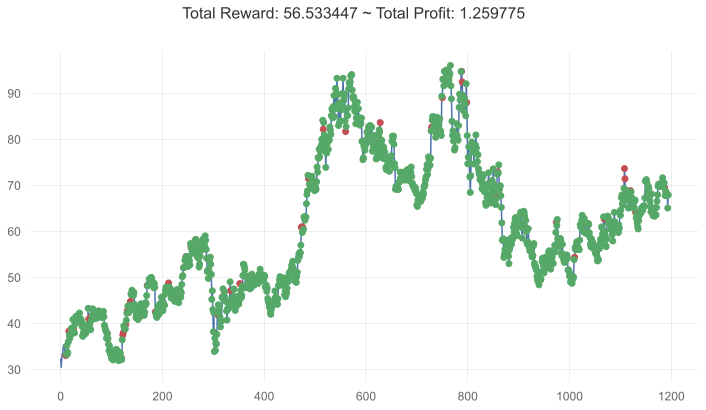

In [ ]:
# Plot results
plt.figure(figsize=(12, 6))
env.unwrapped.render_all()
plt.show()

## 6. Evaluate the efficacy of the RL strategy

In [ ]:
# Calculate metrics and visualize plots for the DeepQ-Learning strategy
qs.extend_pandas()

net_worth = pd.Series(env.unwrapped.history['total_profit'], index=mu_data.index[0:1184])
rl_returns = net_worth.pct_change().iloc[1:]

rl_returns = rl_returns.tz_localize(None)

qs.reports.metrics(rl_returns)

                    Strategy
------------------  ----------
Start Period        2019-01-03
End Period          2023-09-14
Risk-Free Rate      0.0%
Time in Market      5.0%

Cumulative Return   25.98%
CAGR﹪              3.45%

Sharpe              0.32
Prob. Sharpe Ratio  75.41%
Sortino             0.46
Sortino/√2          0.32
Omega               1.29

Max Drawdown        -45.14%
Longest DD Days     577

Gain/Pain Ratio     0.29
Gain/Pain (1M)      0.33

Payoff Ratio        0.88
Profit Factor       1.29
Common Sense Ratio  -
CPC Index           0.68
Tail Ratio          -
Outlier Win Ratio   40.93
Outlier Loss Ratio  0.4

MTD                 7.54%
3M                  7.54%
6M                  30.88%
YTD                 30.88%
1Y                  8.0%
3Y (ann.)           3.77%
5Y (ann.)           3.45%
10Y (ann.)          3.45%
All-time (ann.)     3.45%

Avg. Drawdown       -23.35%
Avg. Drawdown Days  281
Recovery Factor     1.18
Ulcer Index         0.21
Serenity Index      0.14


## 7. Fine-tune your algorithms

### 7.1. Optimizing the Exponential Moving Averages parameters

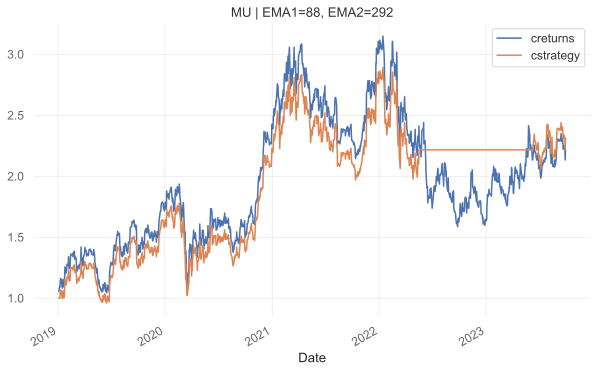

In [ ]:
# Optimizing EMA strategy
import ema
ema_opt = ema.EMA('MU', 40, 20, "2019-01-01", "2023-09-30")

ema_opt.optimize_parameters((10, 100, 2), (100, 400, 2))

ema_opt.plot_results()

### 7.2. Hyperparameter tuning for RL strategy

In [ ]:
# Define hyperparameters ranges
buffer_sizes = [5000, 20000]
learning_start_values = [200, 1000]
train_freq_values = [1, 4]
batch_sizes = [4, 32]
policy_kwargs_options = [{'net_arch': [50]}, {'net_arch': [50, 100]}]
exploration_fractions = [0.05, 0.2]
gammas = [0.8, 0.95]
learning_rates = [0.1, 0.0001]

# Generate all combinations
all_combinations = list(itertools.product(
    buffer_sizes,
    learning_start_values,
    train_freq_values,
    batch_sizes,
    policy_kwargs_options,
    exploration_fractions,
    gammas,
    learning_rates 
))

simulation_time = 5
tau = 1e-4
nb_steps = int(simulation_time // tau)

In [ ]:
# Define the total number of combinations for the progress bar
total_combinations = len(all_combinations)
total_combinations

256

In [ ]:
# Define an evaluation function that returns a performance metric for the model
def get_profit(model):
    # Reset environment to its initial state
    observation, info = env.reset(seed=2023)

    # Initiate dictionary to store action counts
    action_stats = {Actions.Sell: 0, Actions.Buy: 0}

    # Loop to apply the trained model on the environment
    while True:
        action, _states = model.predict(observation)
        action_stats[Actions(action)] += 1
        observation, reward, terminated, truncated, info = env.step(action)

        if terminated or truncated:
           return info["total_profit"]

In [ ]:
# Create a progress bar
progress_bar = tqdm(total=total_combinations, desc='Grid Search Progress', position=0, leave=True)

# Placeholder for results
results = []

# Grid Search
for combination in all_combinations:
    (buffer_size, learning_starts, train_freq, batch_size, policy_kwargs, exploration_fraction, gamma, learning_rate) = combination

    # Define the model
    model = DQN("MlpPolicy", env, buffer_size=buffer_size, learning_starts=learning_starts,
                train_freq=train_freq, batch_size=batch_size, gamma=gamma, policy_kwargs=policy_kwargs,
                exploration_fraction=exploration_fraction, learning_rate=learning_rate, target_update_interval=100,
                tau = 1e-4, verbose=0)

    # Train the model
    model.learn(total_timesteps=nb_steps)

    # Evaluate the model
    performance = get_profit(model)

    # Store results
    results.append((combination, performance))
    
    # Update the progress bar
    progress_bar.update(1)

# Close the progress bar
progress_bar.close()

# Find the best performing combination
best_combination = max(results, key=lambda x: x[1])

print("Best Hyperparameters:", best_combination[0])
print("Best Performance:", best_combination[1])

In [ ]:
# Grid Search Progress: 100%|██████████| 256/256 [1:44:30<00:00, 24.49s/it]  
# Best Hyperparameters: (20000, 200, 4, 4, {'net_arch': [50, 100]}, 0.05, 0.8, 0.0001)
# Best Performance: 1.461245280432302

In [ ]:
# Train with optimal parameters

# Define the model
model = DQN("MlpPolicy", env, 
            buffer_size = 2000, 
            learning_starts = 200,
            train_freq = 4, 
            batch_size = 4, 
            policy_kwargs = {'net_arch': [50, 100]},
            exploration_fraction = 0.05,
            gamma = 0.8,
            learning_rate = 0.0001,
            target_update_interval = 100,
            tau = 1e-4)

# Train the model
model.learn(total_timesteps=nb_steps)

In [ ]:
# Reset environment to its initial state
observation, info = env.reset(seed=2023)

# Initiate dictionary to store action counts
action_stats = {Actions.Sell: 0, Actions.Buy: 0}

# Loop to apply the trained model on the environment
while True:
    action, _states = model.predict(observation)
    action_stats[Actions(action)] += 1
    observation, reward, terminated, truncated, info = env.step(action)

    if terminated or truncated:
        print("info:", info)
        print("action_stats:", action_stats)
        break

env.close()

info: {'total_reward': 32.438499450683594, 'total_profit': 1.0515598998705167, 'position': <Positions.Long: 1>}
action_stats: {<Actions.Sell: 0>: 59, <Actions.Buy: 1>: 1125}


## 8. Compare and interpret the results

### 8.1. Compare between non-optimized and optimized EMA strategy

In [ ]:
# Normal EMA
ema_norm = ema_strat['strategy'].tz_localize(None)
# Optimized EMA
ema_optz = ema_strategy(mu_data, 88, 292)
ema_optz = ema_optz['strategy'].tz_localize(None)

qs.reports.metrics(ema_optz, ema_norm)

### 8.2. Compare between optimized EMA strategy and optimized RL strategy

In [ ]:
# Calculate metrics and visualize plots
qs.extend_pandas()

net_worth = pd.Series(env.unwrapped.history['total_profit'], index=mu_data.index[0:1184])
rl_returns = net_worth.pct_change().iloc[1:]

rl_returns = rl_returns.tz_localize(None)

qs.reports.full(rl_returns, ema_optz)